# Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

Собирать данные такими опросниками не так легко: компания большая, и всех сотрудников надо сначала оповестить об опросе, а затем проследить, что все его прошли. 

**Задачи:**
1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. Удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

In [1]:
#устанавливаем пипы
!pip install scikit-learn -q
!pip install --upgrade scikit-learn -q
!pip install phik -q
!pip install shap==0.45.1 -q
!pip install matplotlib==3.5.0 -q

In [2]:
#импортируем библиотеки
import pandas as pd
import warnings
warnings.simplefilter("ignore") 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st

import re

import phik
from phik.report import plot_correlation_matrix

import sklearn

from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, 
                                     RandomizedSearchCV)
from sklearn.preprocessing import (OneHotEncoder, 
                                   OrdinalEncoder, 
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   LabelEncoder, 
                                   PolynomialFeatures, 
                                   RobustScaler)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier,  DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (roc_auc_score, 
                             accuracy_score, 
                             confusion_matrix, 
                             mean_squared_error, 
                             mean_absolute_error, 
                             r2_score, 
                             make_scorer)

In [3]:
#проверяем версию sklearn
print(sklearn.__version__)

1.6.1


In [4]:
#введем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Задача 1. Предсказание уровня удовлетворённости сотрудника

## Загрузка данных

Заказчик предоставил уже готовые тренировочные и тестовые данные.

In [5]:
#сзагружаем данные
X_train_full = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep=',')
X_test = pd.read_csv('/datasets/test_features.csv', sep=',')
y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep=',')


#выведем несколько строк и проверим какие данные в них содержатся, а также выведем информацию о датафрейме
display(X_train_full.head(5))
X_train_full.info()
print()
display(X_test.head(5))
X_test.info()
print()
display(y_test.head(5))
y_test.info()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB



,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


Мы вывели по несколько строчек из каждого датафрейма, просмотрели и изучили общую информацию по каждому из них. Исходя из этого можно сделать следующие выводы:

* Датафреймы содержат данные, которые и должны в них содержаться. 
* Содержание соответствуют названию.
* Имеются пропуски значений, в тренировочном и тестовом датафрейме есть несколько пропусков в столбцах debt и level.
* Типы данных соответствуют действительным.
* Требуется проверка на дубликаты.

## Предобработка данных

Отсортируем значения в датафреймах по возрастанию в колонке id, чтобы в дальнейшем не возникало путаницы.

In [6]:
X_train_full = X_train_full.sort_values(by = 'id')
X_test = X_test.sort_values(by = 'id')
y_test = y_test.sort_values(by = 'id')

### Создание нового столбца

Переведём столбец с оценками в категориальный признак, где оценки 1-3 будут считаться низкими, так как это среднее и ниже, а 4 и 5 - высокими, так как это выше среднего значения.

In [7]:
#определяем интервалы для категорий
df_new = pd.DataFrame(columns=['evaluation_category','supervisor_evaluation'])
bins = [0, 4, 6]  # 0-3 для низкой, 4-5 для высокой

#определяем метки для категорий
labels = ['низкая', 'высокая']

#создаем новый столбец с категориальным признаком
df_new['evaluation_category'] = pd.cut(X_train_full['supervisor_evaluation'], bins=bins, labels=labels, right=False)
X_train_full['supervisor_evaluation'] = df_new['evaluation_category']

In [8]:
df_new['evaluation_category'] = pd.cut(X_test['supervisor_evaluation'], bins=bins, labels=labels, right=False)
X_test['supervisor_evaluation'] = df_new['evaluation_category']

Переведём столбцы типа category в тип object.

In [9]:
X_test['supervisor_evaluation'] = X_test['supervisor_evaluation'].astype('object')
X_train_full['supervisor_evaluation'] = X_train_full['supervisor_evaluation'].astype('object')

### Проверка наличия дубликатов

In [10]:
print(X_train_full.duplicated().sum())
print(X_test.duplicated().sum())
print(y_test.duplicated().sum())

0
0
0


Явных дубликатов не обнаружено.

Проверим неявные дубликаты.

In [11]:
#дадим имена датафреймам чтобы использовать их как определитель
X_train_full.__name__ = 'X_train_full'
X_test.__name__ = 'X_test'
y_test.__name__ = 'y_test'

df_list = [X_train_full, X_test, y_test]

#переберем все наши датафреймы в цикле

for df in df_list:
#выберем все столбцы, которые имеют тип данных 'object' и после выведем списки их уникальных значений
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
#цикл for для вывода списков уникальных значений по каждому категориальному столбцу
    print(f"Информация по датафрейму '{df.__name__}':\n")
    for column in categorical_columns:
        unique_values = df[column].unique()
        print(f"Уникальные значения для столбца '{column}': {unique_values}")
    print()

Информация по датафрейму 'X_train_full':

Уникальные значения для столбца 'dept': ['purchasing' 'sales' 'technology' 'hr' 'marketing' nan]
Уникальные значения для столбца 'level': ['junior' 'middle' 'sinior' nan]
Уникальные значения для столбца 'workload': ['low' 'medium' 'high']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_evaluation': ['высокая' 'низкая']

Информация по датафрейму 'X_test':

Уникальные значения для столбца 'dept': ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']
Уникальные значения для столбца 'level': ['junior' 'middle' 'sinior' nan]
Уникальные значения для столбца 'workload': ['low' 'high' 'medium' ' ']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_evaluation': ['высокая' 'низкая']

Информация п

Есть небольшая опечатка в слове **sEnior** и пустые значения ' '. Исправим это.

In [12]:
X_train_full['level'] = X_train_full['level'].str.replace('sinior', 'senior')
X_test['level'] = X_test['level'].str.replace('sinior', 'senior')

In [13]:
X_test['workload'] = X_test['workload'].replace(' ', np.nan)
X_test['dept'] = X_test['dept'].replace(' ', np.nan)

Проверим изменения.

In [14]:
#дадим имена датафреймам чтобы использовать их как определитель
X_train_full.__name__ = 'X_train_full'
X_test.__name__ = 'X_test'
y_test.__name__ = 'y_test'

df_list = [X_train_full, X_test, y_test]

#переберем все наши датафреймы в цикле

for df in df_list:
#выберем все столбцы, которые имеют тип данных 'object' и после выведем списки их уникальных значений
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
#цикл for для вывода списков уникальных значений по каждому категориальному столбцу
    print(f"Информация по датафрейму '{df.__name__}':\n")
    for column in categorical_columns:
        unique_values = df[column].unique()
        print(f"Уникальные значения для столбца '{column}': {unique_values}")
    print()

Информация по датафрейму 'X_train_full':

Уникальные значения для столбца 'dept': ['purchasing' 'sales' 'technology' 'hr' 'marketing' nan]
Уникальные значения для столбца 'level': ['junior' 'middle' 'senior' nan]
Уникальные значения для столбца 'workload': ['low' 'medium' 'high']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_evaluation': ['высокая' 'низкая']

Информация по датафрейму 'X_test':

Уникальные значения для столбца 'dept': ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan]
Уникальные значения для столбца 'level': ['junior' 'middle' 'senior' nan]
Уникальные значения для столбца 'workload': ['low' 'high' 'medium' nan]
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_evaluation': ['высокая' 'низкая']

Информация по да

**Вывод по предобработке данных**

* Исправлены опечатки в данных.
* Заполнены пропуски ' ' значением nan.
* Оценка качества работы сотрудника переведена в значения "низкая"(1-3) и "высокая"(4-5).

В данных встречаются пропуски, но мы не будем удалять данные пока. Сделаем это при создании пайплайна.

## Исследовательский анализ данных

Для исследовательского анализа данных выведем гистограммы для всех численных признаков и круговые диаграммы для категориальных.

['id', 'employment_years', 'salary', 'job_satisfaction_rate']
['id', 'employment_years', 'salary']
['id', 'job_satisfaction_rate']


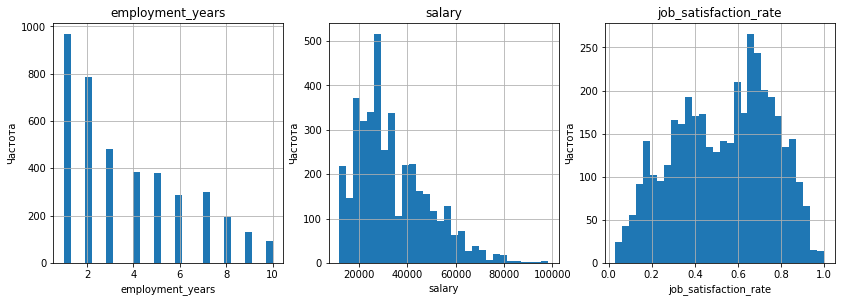

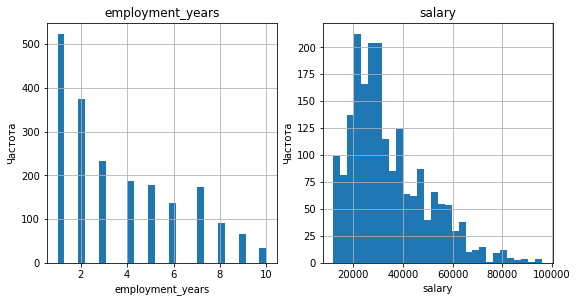

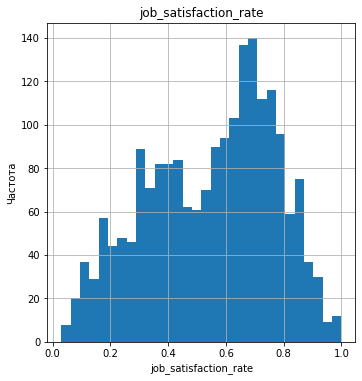

In [15]:
# выведем графики для каждого датафрема и для его численных столбцов
df_list = [X_train_full, X_test, y_test]
for df in df_list:
    
# Выберем все столбцы, которые имеют тип данных 'float','int' и после выведем списки их уникальных значений
    
    num_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    print(num_columns)
    
    #исключим столбец id из результатов
    if 'id' in num_columns:
        num_columns.remove('id')
        
    plt.figure(figsize=(14, 15))
    for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
        plt.subplot(3, 3, i + 1)  # 3 строки, 3 столбца, текущий график
    
    # Строим гистограмму для текущего столбца
        df[column].hist(bins=30)
    
    # Добавляем заголовок с названием столбца
        plt.title(column)
    
    # Добавляем метки для осей
        plt.xlabel(column)
        plt.ylabel('Частота')
        
plt.tight_layout()
plt.show()


DataFrame: X_train_full
Continuous variables: ['salary', 'job_satisfaction_rate']
Discrete variables: ['employment_years']


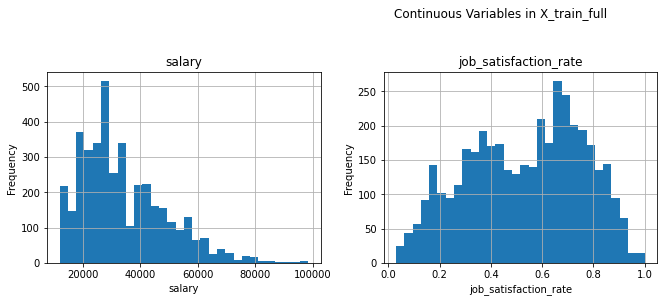

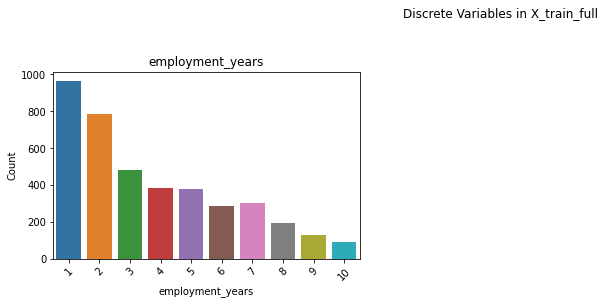


DataFrame: X_test
Continuous variables: ['salary']
Discrete variables: ['employment_years']


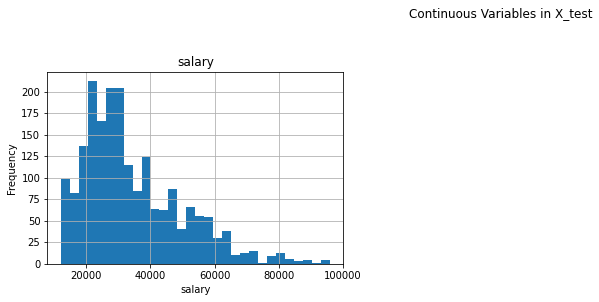

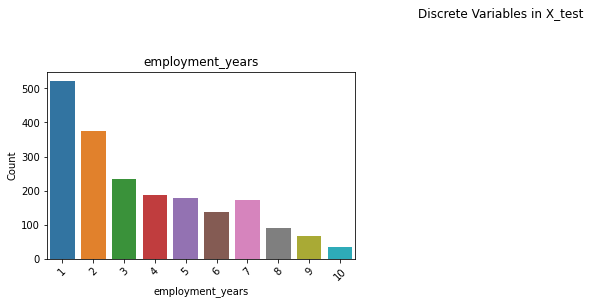


DataFrame: y_test
Continuous variables: ['job_satisfaction_rate']
Discrete variables: []


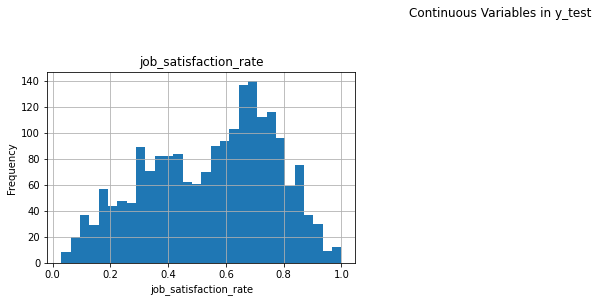

In [17]:
df_list = [X_train_full, X_test, y_test]
df_names = ['X_train_full', 'X_test', 'y_test']

for df, name in zip(df_list, df_names):
    # Выбираем числовые колонки
    num_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    if 'id' in num_columns:
        num_columns.remove('id')
    
    # Разделяем на непрерывные и дискретные переменные
    continuous_vars = []
    discrete_vars = []
    
    for column in num_columns:
        # Эвристика: если уникальных значений много (>20) - считаем непрерывной
        if df[column].nunique() > 20:
            continuous_vars.append(column)
        else:
            discrete_vars.append(column)
    
    print(f"\nDataFrame: {name}")
    print("Непрерывные величины:", continuous_vars)
    print("Дискретные величины:", discrete_vars)
    
    # Визуализация непрерывных переменных
    if continuous_vars:
        plt.figure(figsize=(14, 10))
        plt.suptitle(f'Непрерывные величины в {name}', y=1.02)
        
        for i, column in enumerate(continuous_vars):
            plt.subplot(3, 3, i + 1)  # 3 строки, 3 столбца
            df[column].hist(bins=30)
            plt.title(column)
            plt.xlabel(column)
            plt.ylabel('Частота')
        
        plt.tight_layout()
        plt.show()
    
    # Визуализация дискретных переменных
    if discrete_vars:
        plt.figure(figsize=(14, 10))
        plt.suptitle(f'Дискретные величины в {name}', y=1.02)
        
        for i, column in enumerate(discrete_vars):
            plt.subplot(3, 3, i + 1)  # 3 строки, 3 столбца
            sns.countplot(data=df, x=column)
            plt.title(column)
            plt.xlabel(column)
            plt.ylabel('Количество')
            plt.xticks(rotation=45)  # Поворачиваем подписи для лучшей читаемости
        
        plt.tight_layout()
        plt.show()

Можно сделать выводы о распределении значений, исходя из графиков. Большинство из них распределены **распределением Пуассона**.
О сравнении тренировочной и тестовой выборке можно сказать что графики очень схожи.

Выведем теперь боксплоты для всех тех же признаков, и так же рассмотрим данные на выбросы

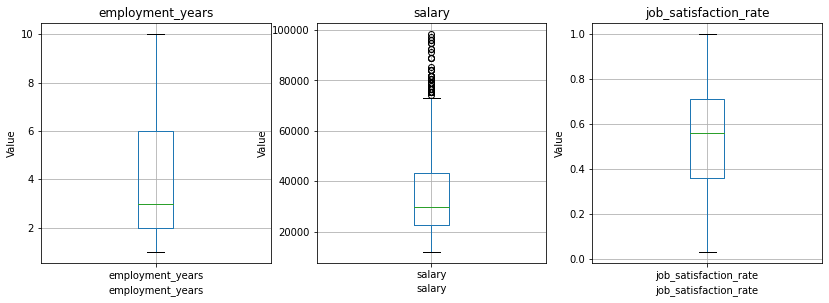

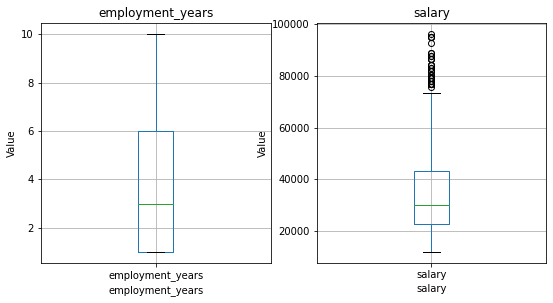

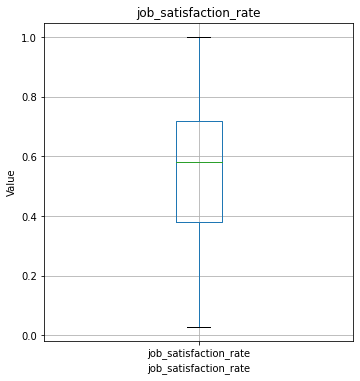

In [16]:
df_list = [X_train_full, X_test, y_test]
for df in df_list:
    
# Выберем все столбцы, которые имеют тип данных 'object' и после выведем списки их уникальных значений
    
    num_columns = df.select_dtypes(include=['float64','int64']).columns.tolist()
    #исключим столбец id из результатов
    if 'id' in num_columns:
        num_columns.remove('id')
        
    plt.figure(figsize=(14, 15))
    for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
        plt.subplot(3, 3, i + 1)  # 2 строки, 3 столбца, текущий график
    
    # Строим график размаха для текущего столбца
        df.boxplot(column=column, ax=plt.gca())
    
    # Добавляем заголовок с названием столбца
        plt.title(column)
    
    # Добавляем метки для осей
        plt.xlabel(column)
        plt.ylabel('Value')
        
plt.tight_layout()
plt.show()

Явных выборосов не видно. В колонке с размером зарплаты встречают выбивающиеся значения. Это вполне нормально, так как всегда есть работник, которые получают больше основной массы сотрудников. Эти значения встречаются в обеих выборках, имеют схожий вид и вполне себе имеют место быть в реальной жизни. Их мы не трогаем.

Рассмотрим данные категориальных значений.

Круговые диаграммы для всех категориальных переменных:



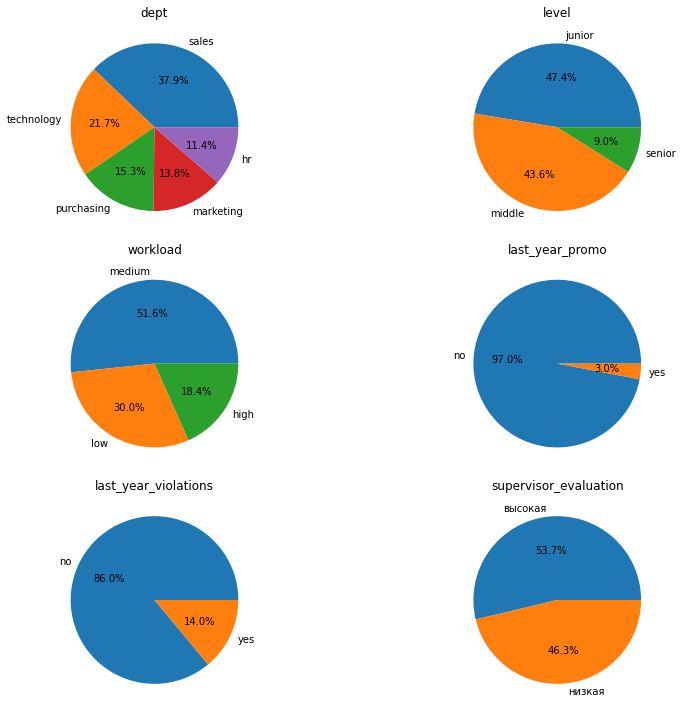

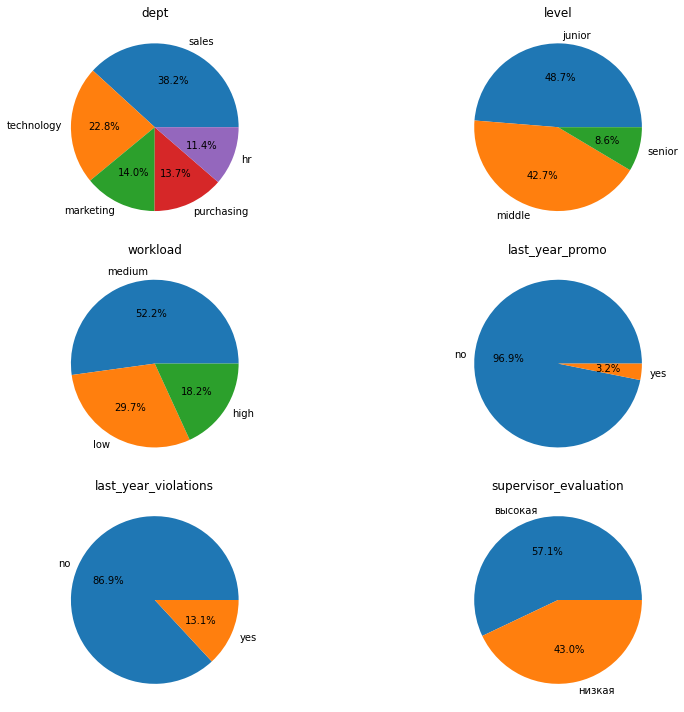

<Figure size 1008x720 with 0 Axes>

In [18]:
print('Круговые диаграммы для всех категориальных переменных:\n')

# Цикл для итерации по каждому датафрейму в списке
for df in df_list:
    plt.figure(figsize=(14, 10))
    
    # Получаем список категориальных столбцов для текущего датафрейма
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

    # Цикл для итерации по каждому категориальному столбцу
    for i, column in enumerate(categorical_columns):
        # Создаем subplot для текущего столбца
        plt.subplot(3, 2, i + 1)  # 3 строки, 2 столбца, текущий график
    
        # Подсчитываем количество каждого уникального значения в текущем столбце
        data = df[column].value_counts()
    
        # Строим круговую диаграмму для текущего столбца
        plt.pie(data, labels=data.index, autopct='%1.1f%%')
    
        # Добавляем заголовок с названием столбца
        plt.title(column)

    # Отображаем все круговые диаграммы для текущего датафрейма
    plt.tight_layout()
    plt.show()

Из данных графиков следует:

* Тренировочная и тестовая выборка одинаковы по процентному соотношению категориальных признаков между собой.
* Большинство работников (38%) работают в отделе продаж и почти 23% - в отделе технологий.
* Почти 50% - Junior специалисты, а 42% - Middle. Оставшиеся 8.5% - Senior.
* Чуть больше половины сотрудников загружены средне.
* Повышение в прошлом году было только у 3% рабочих
* Нарушение трудового договора наблюдалось у 13%.

У нас наблюдается сильный дисбаланс классов, если говорить о таких признаках как Повышение в прошлом году и Нарушение трудового договора в прошлом году. Надо будет учесть это при подговке данных и использовать один из методов устранения дисбаланса классов.

### Корреляционный анализ данных

Выведем матрицу корреляции.

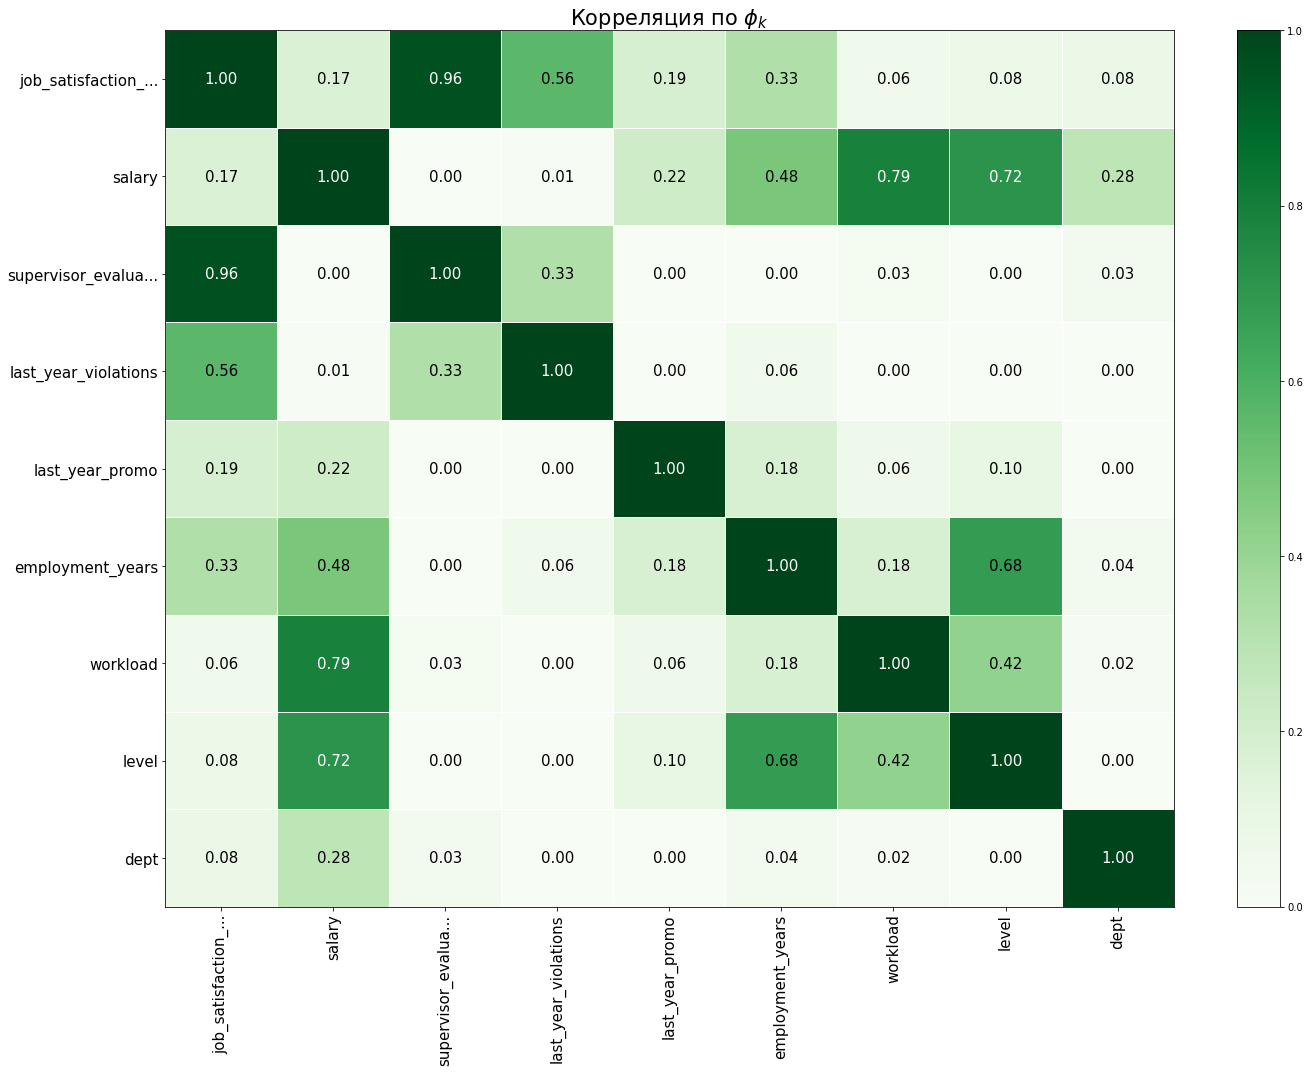

In [19]:
df_corr = X_train_full.drop(columns=['id'])
#соберем все численные переменные в датафрейме с помощью функции и сохраним их в переменную
num_columns = df_corr.select_dtypes(include=['float64','int64']).columns.tolist()

phik_matrix = df_corr.phik_matrix(interval_cols=num_columns)

#строим матрицу корреляции Phik
plot_correlation_matrix(phik_matrix.values, 
                       x_labels = phik_matrix.columns,
                       y_labels = phik_matrix.index,
                       vmin = 0, vmax = 1,color_map = 'Greens',
                       title = r'Корреляция по $\phi_k$',
                       fontsize_factor = 1.5, 
                       figsize = (20,15)
                       )

Следует отметить сильную корреляцию между **оценкой работы сотрудника начальством** и целевым признаком (**0.96**). Так же корреляцию наблюдает с таким признаком как **нарушение трудового договора за последний год** - 0.56.

Мультиколлинеарность между входными признаками замечена не была. 

**Выводы по исследовательскому анализу данных**

* Тренировочная и тестовая выборка одинаковы по процентному соотношению категориальных признаков между собой.
* Большинство работников (38%) работают в отделе продаж и почти 23% - в отделе технологий.
* Почти 50% - Junior специалисты, а 42% - Middle. Оставшиеся 8.5% - Senior.
* Чуть больше половины сотрудников загружены средне.
* Повышение в прошлом году было только у 3% рабочих
* Нарушение трудового договора наблюдалось у 13%.
* Сильный дисбаланс классов в некоторых данных.
* Корреляция между **оценкой работы сотрудника начальством** и **удовлетворенностью сотрудника**. 
* Мультиколлинеарности между входными признаками не обнаружено.

## Использование пайплайна

### Подготовка данных

Разделим тренировочные данные на входные признаки и целевой.

In [20]:
#разделим наш датафрейм на тестовую и тренировочную выборки
X_train = X_train_full.drop(
        [
            'job_satisfaction_rate'
        ], 
        axis=1
    )
y_train = X_train_full['job_satisfaction_rate']

Создадим списки для каждого кодирования.

In [21]:
#для удобства выведем списки всех численных переменных, созданные ранее с помощью функции
num_columns = X_train_full.select_dtypes(include=['float64','int64']).columns.tolist()
num_columns

['id', 'employment_years', 'salary', 'job_satisfaction_rate']

In [22]:
cat_columns = X_train_full.select_dtypes(include=['object']).columns.tolist()
for column in cat_columns:
        unique_values = X_train_full[column].unique()
        print(f"Уникальные значения для столбца '{column}': {unique_values}")

Уникальные значения для столбца 'dept': ['purchasing' 'sales' 'technology' 'hr' 'marketing' nan]
Уникальные значения для столбца 'level': ['junior' 'middle' 'senior' nan]
Уникальные значения для столбца 'workload': ['low' 'medium' 'high']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_evaluation': ['высокая' 'низкая']


In [23]:
# признаки для OneHotEncoder
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

# признаки для OrdinalEncoder
ord_columns = ['level','workload', 'supervisor_evaluation']

# численные признаки
num_columns = ['employment_years', 'salary']

### Создание пайплана

Начинаем создавать пайплайн. 

In [24]:
# cоздаём пайплайн для подготовки признаков из списка ohe_columns:
ohe_pipe = Pipeline([
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (    'ohe', 
            OneHotEncoder(sparse_output=False, handle_unknown='ignore',drop='first')
        )
])

In [25]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns:
ord_pipe = Pipeline([
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior','middle','senior'],
                    ['low','medium','high'],
                    ['низкая', 'высокая']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
       (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
])

In [26]:
# создаём общий пайплайн для объединения шагов подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)   
    ], 
    remainder =  'passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ord',
                                                  Ord

In [27]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

Создадим словарь для каждой модели, в котором укажем гиперпараметры для дальнейшего перебора.

In [28]:
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(1,6),
        'models__min_samples_split': range(2,8),
        'models__min_samples_leaf': range(2, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
     }
]

## Обучение модели

Для оценки качества работы модели создадим свою метрику, которая назвается SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение». Так же в дальшейшем для поиска лучшей модели будем использовать метод перебора всех значений по сетке GridSearchCV, так как он как раз работает с метриками для линейной регрессии.

In [29]:
def custom_metric(y_true, y_pred):
    # рассчитываем значение метрики
    numerator = 100 / len(y_true) * np.sum(np.abs(y_true - y_pred))
    denominator = np.abs(y_true) + np.abs(y_pred)
    denominator[denominator == 0] = np.nan  # Исключаем деление на 0
    denominator = np.nanmean(denominator) / 2
    score = numerator / denominator
    return score

# создаем scorer
SMAPE = make_scorer(custom_metric, greater_is_better=False)

In [30]:
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=SMAPE,
    n_jobs=-1
)

Обучим модель на тренировочной выборке.

In [31]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('simpleImputer_ohe',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['dept',
                                                                          'last_year_promo',
                                                                          'last_year_violations']),
                                                                        ('ord',
                                                                         Pipeline(...
                          'models__max_depth': range(1, 6),
                          'models__min_samples_leaf': range(2, 8),
                          'models__min_samples_split': range(2, 8),
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']},
                         {'models': [LinearRegression()],
                          'preprocessor__num': [StandardScaler(),
                                                MinMaxScaler(),
                                                'passthrough']}],
             scoring=make_scorer(custom_metric, greater_is_better=False, response_method='predict'))

In [32]:
print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [33]:
X_test = X_test.sort_values(by = 'id')
y_test = y_test.sort_values(by = 'id')

In [34]:
X_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
1172,100298,hr,junior,low,2,no,no,высокая,19200
852,100480,marketing,junior,low,4,no,no,высокая,16800
848,100503,purchasing,middle,high,5,no,no,высокая,55200
524,100610,sales,middle,medium,5,no,no,высокая,43200
476,100692,sales,middle,high,6,no,no,высокая,48000


In [35]:
y_test_SMAPE = pd.Series(y_test['job_satisfaction_rate'])

Рассчитаем значение метрики SMAPE.

In [36]:
score = SMAPE(grid_search, X_test, y_test_SMAPE)
print(f'Метрика SMAPE на тестовой выборке: {score}')

Метрика SMAPE на тестовой выборке: -13.961644594589453


Мы получили значени SMAPE, которое по модулю равно 13.9. Делаем вывод, что наша модель работает.
На тренировочной выборке значение получилось 14.4, а на тестовой 13.9, что и требовалось в задаче.

## Вывод по Задаче 1.

Мы добились желаемого показателя метрики, и достигли этого при помощи лучшей из подобранных моделей - LinearRegression(). Перебор был между деревом регрессии и линейной регрессией. 

У входных данных была достаточная линейная зависимость с целевым признаком, из-за чего метрика получилась выше для ЛинейнойРегрессии.

</span><br><span style="color: purple; font-weight: bold">Во время первой иттерации при кодировании копировал данные из задания и указал во время ord кодирования sinior вместо исправленного sEnior. Из-за этой ошибки модель указывала лучшей метрику ДеревоРегрессий со значением SMAPE 15.1.</span>

# Задача 2. Предсказание увольнения сотрудника из компании

## Загрузка данных

In [37]:
X_train_full2 = pd.read_csv('/datasets/train_quit.csv', sep=',')
X_test2 = pd.read_csv('/datasets/test_features.csv', sep=',')
y_test2 = pd.read_csv('/datasets/test_target_quit.csv', sep=',')


#выведем несколько строк и проверим какие данные в них содержатся, а также выведем информацию о датафрейме
display(X_train_full2.head(5))
X_train_full2.info()
print()
display(X_test2.head(5))
X_test2.info()
print()
display(y_test2.head(5))
y_test2.info()
print()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB



,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB



,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB



Мы вывели по несколько строчек из каждого датафрейма, просмотрели и изучили общую информацию по каждому из них. Исходя из этого можно сделать следующие выводы:

* Датафремы содержат данные, которые и должны в них содержаться. 
* Содержание соответствуют названию.
* Имеются пропуски значений, но теперь только в тестовой выборке в столбцах debt и level.
* Типы данных соответствуют действительным.
* Нужно сделать проверку на дубликаты.

Пропуски заполним во время подготовки пайплайна.

## Предобработка данных

### Создание нового столбца

Отсортируем значения в датафреймах по возрастанию в колонке id, чтобы в дальнейшем не возникало путаницы.

In [38]:
X_train_full2 = X_train_full2.sort_values(by = 'id')
X_test2 = X_test2.sort_values(by = 'id')
y_test2 = y_test2.sort_values(by = 'id')

Повторим те же действия для создания категорий из первого задания.

In [39]:
# Определяем интервалы для категорий
df_new = pd.DataFrame(columns=['evaluation_category','supervisor_evaluation'])
bins = [0, 4, 6]  # 0-3 для низкой, 4-5 для высокой

# Определяем метки для категорий
labels = ['низкая', 'высокая']

# Создаем новый столбец с категориальным признаком
df_new['evaluation_category'] = pd.cut(X_train_full2['supervisor_evaluation'], bins=bins, labels=labels, right=False)
X_train_full2['supervisor_evaluation'] = df_new['evaluation_category']

In [40]:
df_new['evaluation_category'] = pd.cut(X_test2['supervisor_evaluation'], bins=bins, labels=labels, right=False)
X_test2['supervisor_evaluation'] = df_new['evaluation_category']

In [41]:
X_test2['supervisor_evaluation'] = X_test2['supervisor_evaluation'].astype('object')
X_train_full2['supervisor_evaluation'] = X_train_full2['supervisor_evaluation'].astype('object')

### Проверка наличия дубликатов

In [42]:
print(X_train_full2.duplicated().sum())
print(X_test2.duplicated().sum())
print(y_test2.duplicated().sum())

0
0
0


Явных дубликатов не обнаружено.

Проверим наличие неявных дубликатов.

In [43]:
X_train_full2.__name__ = 'X_train_full2'
X_test2.__name__ = 'X_test2'
y_test2.__name__ = 'y_test2'

df_list2 = [X_train_full2, X_test2, y_test2]
#переберем все наши датафреймы в цикле

for df in df_list2:
# Выберем все столбцы, которые имеют тип данных 'object' и после выведем списки их уникальных значений
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
# Цикл for для вывода списков уникальных значений по каждому категориальному столбцу
    print(f"Информация по датафрейму '{df.__name__}':\n")
    for column in categorical_columns:
        unique_values = df[column].unique()
        print(f"Уникальные значения для столбца '{column}': {unique_values}")
    print()

Информация по датафрейму 'X_train_full2':

Уникальные значения для столбца 'dept': ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения для столбца 'level': ['junior' 'middle' 'sinior']
Уникальные значения для столбца 'workload': ['medium' 'high' 'low']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_evaluation': ['низкая' 'высокая']
Уникальные значения для столбца 'quit': ['yes' 'no']

Информация по датафрейму 'X_test2':

Уникальные значения для столбца 'dept': ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan ' ']
Уникальные значения для столбца 'level': ['junior' 'middle' 'sinior' nan]
Уникальные значения для столбца 'workload': ['low' 'high' 'medium' ' ']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_

Есть небольшая опечатка в слове **sEnior** и пустые значения ' '. Исправим это.

In [44]:
X_train_full2['level'] = X_train_full2['level'].str.replace('sinior', 'senior')
X_test2['level'] = X_test2['level'].str.replace('sinior', 'senior')

In [45]:
X_test2['workload'] = X_test2['workload'].replace(' ', np.nan)
X_test2['dept'] = X_test2['dept'].replace(' ', np.nan)

Проверяем изменения.

In [46]:
X_train_full2.__name__ = 'X_train_full2'
X_test2.__name__ = 'X_test2'
y_test2.__name__ = 'y_test2'

df_list2 = [X_train_full2, X_test2, y_test2]
#переберем все наши датафреймы в цикле

for df in df_list2:
# Выберем все столбцы, которые имеют тип данных 'object' и после выведем списки их уникальных значений
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
# Цикл for для вывода списков уникальных значений по каждому категориальному столбцу
    print(f"Информация по датафрейму '{df.__name__}':\n")
    for column in categorical_columns:
        unique_values = df[column].unique()
        print(f"Уникальные значения для столбца '{column}': {unique_values}")
    print()

Информация по датафрейму 'X_train_full2':

Уникальные значения для столбца 'dept': ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения для столбца 'level': ['junior' 'middle' 'senior']
Уникальные значения для столбца 'workload': ['medium' 'high' 'low']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_evaluation': ['низкая' 'высокая']
Уникальные значения для столбца 'quit': ['yes' 'no']

Информация по датафрейму 'X_test2':

Уникальные значения для столбца 'dept': ['hr' 'marketing' 'purchasing' 'sales' 'technology' nan]
Уникальные значения для столбца 'level': ['junior' 'middle' 'senior' nan]
Уникальные значения для столбца 'workload': ['low' 'high' 'medium' nan]
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_eval

**Вывод по предобработке данных**

* Исправлены опечатки в данных.
* Заполнены пропуски ' ' значением nan.
* Оценка качества работы сотрудника переведена в значения "низкая"(1-3) и "высокая"(4-5).

В данных встречаются пропуски, но мы не будем удалять данные пока. Сделаем это при создании пайплайна.

## Исследовательский анализ данных

Для исследовательского анализа данных выведем гистограммы для всех численных признаков и круговые диаграммы для категориальных.

['id', 'employment_years', 'salary']
['id', 'employment_years', 'salary']
['id']


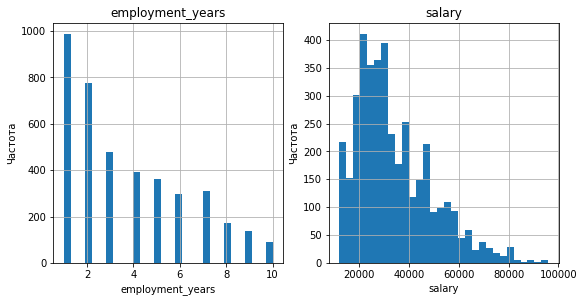

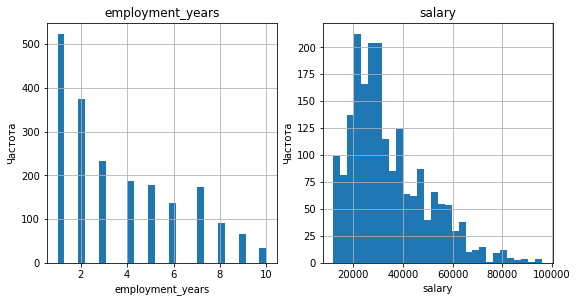

<Figure size 1008x1080 with 0 Axes>

In [47]:
# выведем графики для каждого датафрема и для его численных столбцов
df_list2 = [X_train_full2, X_test2, y_test2]
for df in df_list2:
# Выберем все столбцы, которые имеют тип данных 'float','int' и после выведем списки их уникальных значений
    
    num_columns = df.select_dtypes(include=['float64','int64']).columns.tolist()
    print(num_columns)
    
    #исключим столбец id из результатов
    if 'id' in num_columns:
        num_columns.remove('id')
        
    plt.figure(figsize=(14, 15))
    for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
        plt.subplot(3, 3, i + 1)  # 3 строки, 3 столбца, текущий график
    
    # Строим гистограмму для текущего столбца
        df[column].hist(bins=30)
    
    # Добавляем заголовок с названием столбца
        plt.title(column)
    
    # Добавляем метки для осей
        plt.xlabel(column)
        plt.ylabel('Частота')
        
plt.tight_layout()
plt.show()


DataFrame: X_train_full2
Непрерывные величины: ['salary']
Дискретные величины: ['employment_years']


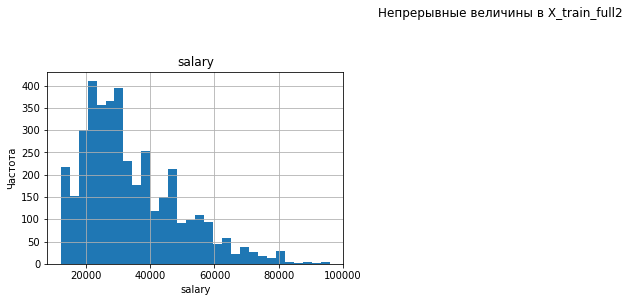

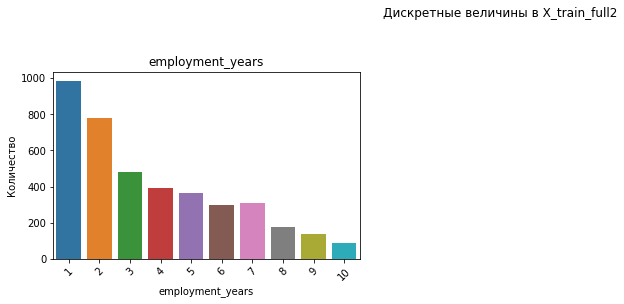


DataFrame: X_test2
Непрерывные величины: ['salary', 'job_satisfaction_rate']
Дискретные величины: ['employment_years']


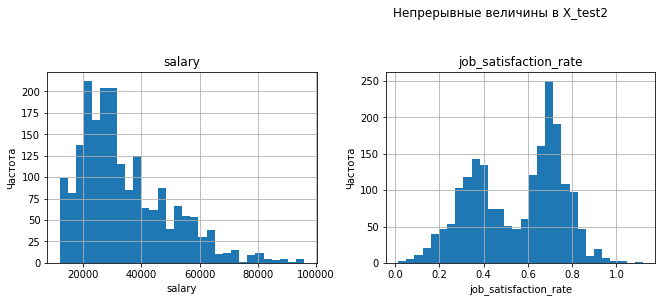

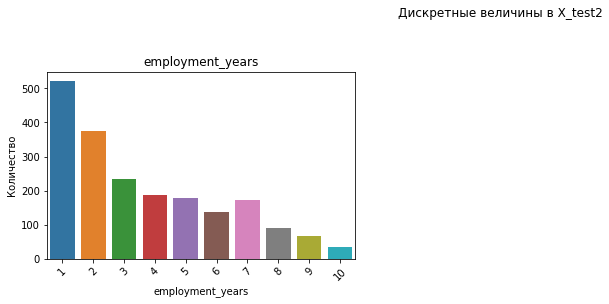

AttributeError: 'numpy.ndarray' object has no attribute 'select_dtypes'

In [79]:
df_list2 = [X_train_full2, X_test2, y_test2]
df_names2 = ['X_train_full2', 'X_test2', 'y_test2']

for df, name in zip(df_list2, df_names2):
    # Выбираем числовые колонки
    num_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    if 'id' in num_columns:
        num_columns.remove('id')
    
    # Разделяем на непрерывные и дискретные переменные
    continuous_vars = []
    discrete_vars = []
    
    for column in num_columns:
        # Эвристика: если уникальных значений много (>20) - считаем непрерывной
        if df[column].nunique() > 20:
            continuous_vars.append(column)
        else:
            discrete_vars.append(column)
    
    print(f"\nDataFrame: {name}")
    print("Непрерывные величины:", continuous_vars)
    print("Дискретные величины:", discrete_vars)
    
# Визуализация непрерывных переменных
    if continuous_vars:
        plt.figure(figsize=(14, 10))
        plt.suptitle(f'Непрерывные величины в {name}', y=1.02)
        
        for i, column in enumerate(continuous_vars):
            plt.subplot(3, 3, i + 1)  # 3 строки, 3 столбца
            df[column].hist(bins=30)
            plt.title(column)
            plt.xlabel(column)
            plt.ylabel('Частота')
        
        plt.tight_layout()
        plt.show()
    
    # Визуализация дискретных переменных
    if discrete_vars:
        plt.figure(figsize=(14, 10))
        plt.suptitle(f'Дискретные величины в {name}', y=1.02)
        
        for i, column in enumerate(discrete_vars):
            plt.subplot(3, 3, i + 1)  # 3 строки, 3 столбца
            sns.countplot(data=df, x=column)
            plt.title(column)
            plt.xlabel(column)
            plt.ylabel('Количество')
            plt.xticks(rotation=45)  # Поворачиваем подписи для лучшей читаемости
        
        plt.tight_layout()
        plt.show()

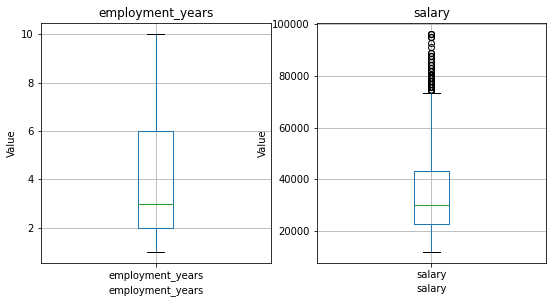

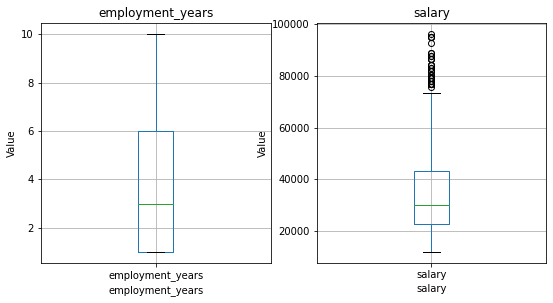

<Figure size 1008x1080 with 0 Axes>

In [48]:
for df in df_list2:
# Выберем все столбцы, которые имеют тип данных 'object' и после выведем списки их уникальных значений
    
    num_columns = df.select_dtypes(include=['float64','int64']).columns.tolist()
    #исключим столбец id из результатов
    if 'id' in num_columns:
        num_columns.remove('id')
        
    plt.figure(figsize=(14, 15))
    for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
        plt.subplot(3, 3, i + 1)  # 2 строки, 3 столбца, текущий график
    
    # Строим график размаха для текущего столбца
        df.boxplot(column=column, ax=plt.gca())
    
    # Добавляем заголовок с названием столбца
        plt.title(column)
    
    # Добавляем метки для осей
        plt.xlabel(column)
        plt.ylabel('Value')
        
plt.tight_layout()
plt.show()

Данные выглядят так же, как и в первой задаче. 

Выведем круговые диаграммы с категориальными признаками.

Круговые диаграммы для всех категориальных переменных:



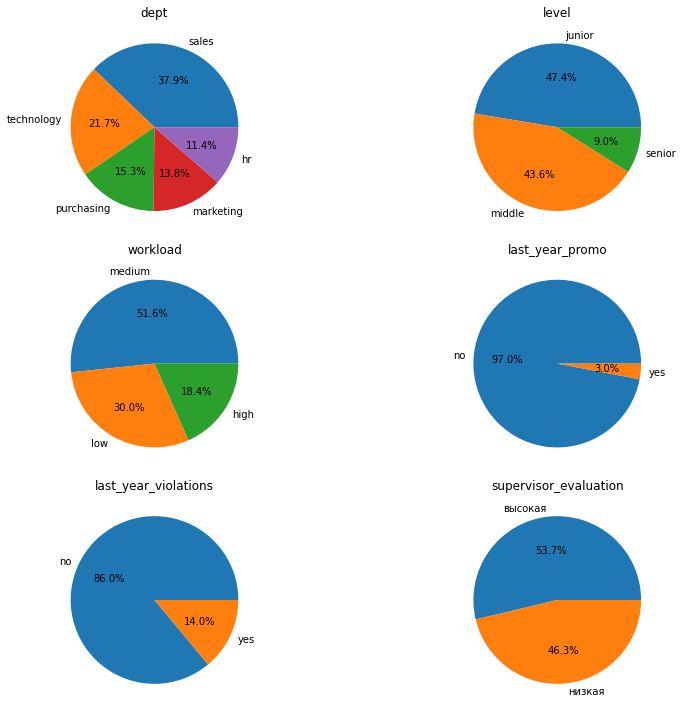

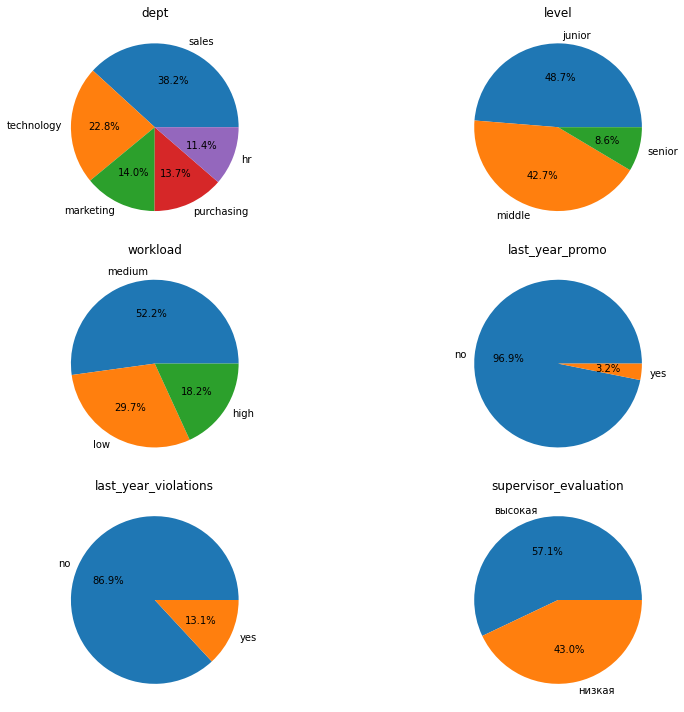

<Figure size 1008x720 with 0 Axes>

In [49]:
print('Круговые диаграммы для всех категориальных переменных:\n')

# Цикл для итерации по каждому датафрейму в списке
for df in df_list:
    plt.figure(figsize=(14, 10))
    
    # Получаем список категориальных столбцов для текущего датафрейма
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

    # Цикл для итерации по каждому категориальному столбцу
    for i, column in enumerate(categorical_columns):
        # Создаем subplot для текущего столбца
        plt.subplot(3, 2, i + 1)  # 3 строки, 2 столбца, текущий график
    
        # Подсчитываем количество каждого уникального значения в текущем столбце
        data = df[column].value_counts()
    
        # Строим круговую диаграмму для текущего столбца
        plt.pie(data, labels=data.index, autopct='%1.1f%%')
    
        # Добавляем заголовок с названием столбца
        plt.title(column)

    # Отображаем все круговые диаграммы для текущего датафрейма
    plt.tight_layout()
    plt.show()

Графики соответствуют графикам из задания 1. Из данных графиков следует:

* Тренировочная и тестовая выборка одинаковы по процентному соотношению категориальных признаков между собой.
* Большинство работников (38%) работают в отделе продаж и почти 23% - в отделе технологий.
* Почти 50% - Junior специалисты, а 42% - Middle. Оставшиеся 8.5% - Senior.
* Чуть больше половины сотрудников загружены средне.
* Повышение в прошлом году было только у 3% рабочих
* Нарушение трудового договора наблюдалось у 13%.
* Наблюдается сильный дисбаланс классов у некоторых данных.

### Корреляционный анализ данных

Выведем матрицу корреляции.

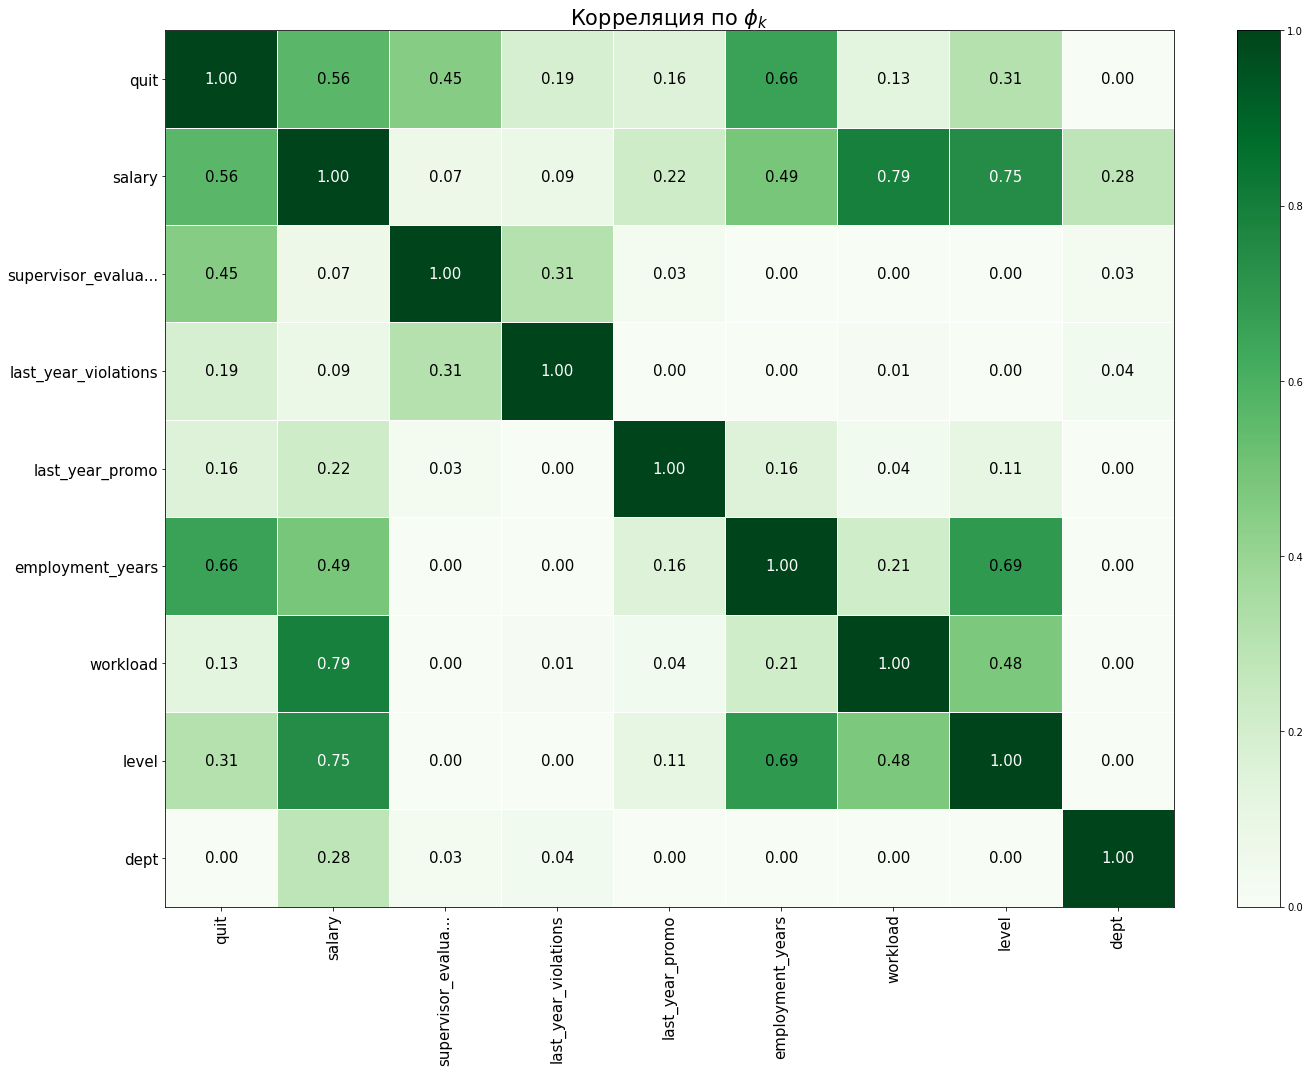

In [50]:
df_corr2 = X_train_full2.drop(columns=['id'])
#соберем все численные переменные в датафрейме с помощью функции и сохраним их в переменную
num_columns = df_corr2.select_dtypes(include=['float64','int64']).columns.tolist()

phik_matrix = df_corr2.phik_matrix(interval_cols=num_columns)

#строим матрицу корреляции Phik
plot_correlation_matrix(phik_matrix.values, 
                       x_labels = phik_matrix.columns,
                       y_labels = phik_matrix.index,
                       vmin = 0, vmax = 1,color_map = 'Greens',
                       title = r'Корреляция по $\phi_k$',
                       fontsize_factor = 1.5, 
                       figsize = (20,15)
                       )

**Вывод по исследовательскому анализу данных** 

* В корреляционной матрице особых зависимостей между входными и целевым признаком обнаружено не было. 
* Утечки признака нет. 
* Больше всего на целевой признак влияют такие признаки как **зарплата** (0.56) и **годы стажа**(0.66).
* Мультиколлинеарности не обнаружено.
* Меньше всего влияют такие показатели как **отдел** (0), **загруженность** (0.13), **повышение** и **нарушение трудового** договора (0.16 и 0.19).

Из значимых изменений у нас появился только столбец **quit**, который показывает увольнение сотрудника из компании. Это целевой признак в данной задаче. Тех, кто уволился намного меньше, чем тех кто остался. Следовательно у нас имеется дисбаланс классов.

## Портрет уволившегося сотрудника

Чтобы составить портрет уволившегося сотрудника создадим датафрейм, где отберем только уволившихся сотрудников и тех, кто не уволнялся, и посмотрим их распределения их признаков, чтобы сопоставить их.

In [51]:
# создаем датафрейм
quit_yes = X_train_full2[X_train_full2['quit'] == 'yes']
quit_no = X_train_full2[X_train_full2['quit'] == 'no']

['id', 'employment_years', 'salary']
['id', 'employment_years', 'salary']


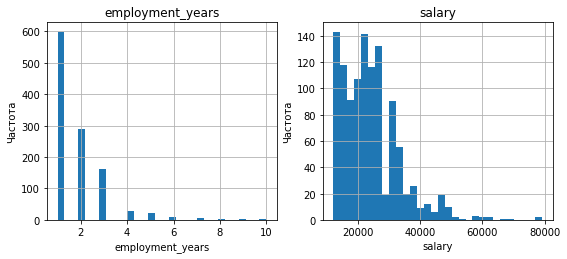

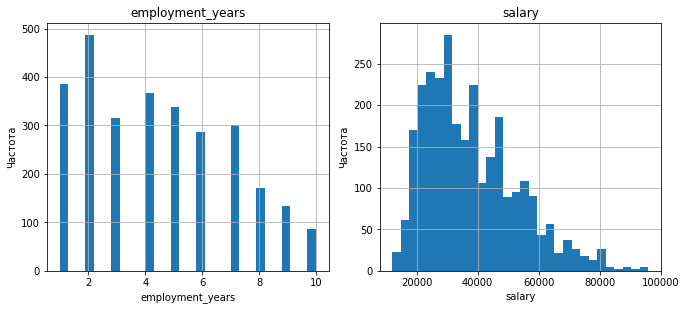

In [52]:
# выводим графики для числовых переменных
df_list3 = [quit_yes, quit_no]
for df in df_list3:
# Выберем все столбцы, которые имеют тип данных 'float','int' и после выведем списки их уникальных значений
    
    num_columns = df.select_dtypes(include=['float64','int64']).columns.tolist()
    print(num_columns)
    
    #исключим столбец id из результатов
    if 'id' in num_columns:
        num_columns.remove('id')
        
    plt.figure(figsize=(14, 8))
    for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
        plt.subplot(2, 3, i + 1)  # 3 строки, 3 столбца, текущий график
    
    # Строим гистограмму для текущего столбца
        df[column].hist(bins=30)
    
    # Добавляем заголовок с названием столбца
        plt.title(column)
    
    # Добавляем метки для осей
        plt.xlabel(column)
        plt.ylabel('Частота')
        
plt.tight_layout()
plt.show()

На графиках мы видим:
* Уволившиеся сотрудники обычно - новички в компании. Редкое исключение, если увольняется тот, кто работает долго.
* Оценка качества работы в среднем 3 балла, в то время как у неуволившихся - 4.
* Среняя зарплата уволившегося - 20 тыс., в то время как у оставшихся сотрудников 20 тыс. - это только начало подьема графика.

Круговые диаграммы для всех категориальных переменных:



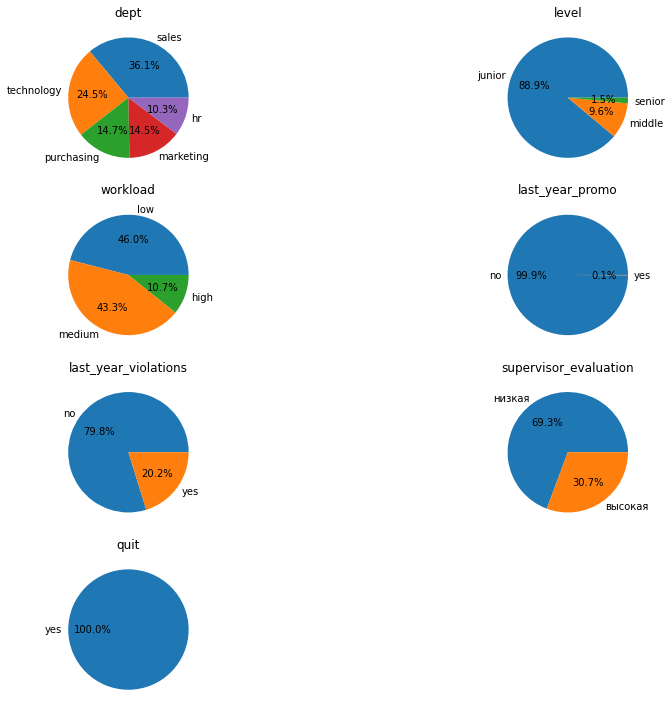

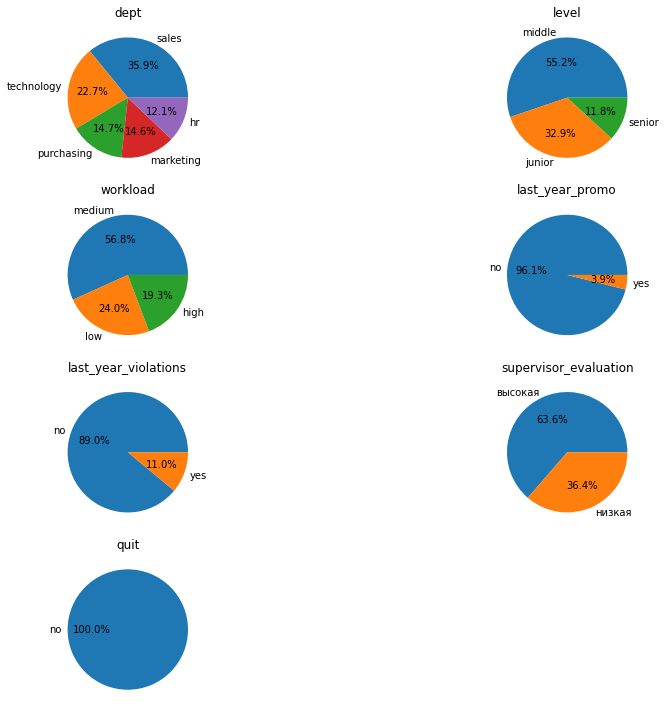

In [53]:
print('Круговые диаграммы для всех категориальных переменных:\n')

# Цикл для итерации по каждому датафрейму в списке
for df in df_list3:
    plt.figure(figsize=(14, 10))
    
    # Получаем список категориальных столбцов для текущего датафрейма
    categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

    # Цикл для итерации по каждому категориальному столбцу
    for i, column in enumerate(categorical_columns):
        # Создаем subplot для текущего столбца
        plt.subplot(4, 2, i + 1)  # 3 строки, 2 столбца, текущий график
    
        # Подсчитываем количество каждого уникального значения в текущем столбце
        data = df[column].value_counts()
    
        # Строим круговую диаграмму для текущего столбца
        plt.pie(data, labels=data.index, autopct='%1.1f%%')
    
        # Добавляем заголовок с названием столбца
        plt.title(column)

    # Отображаем все круговые диаграммы для текущего датафрейма
    plt.tight_layout()
    plt.show()

На круговых диаграммах мы видим:
* Уволившиеся были менее загружены на работе.
* Большинство - это работники уровня Junior.

**Портрет 'Уволившегося сотрудника'**

* Работает в компании около года.
* Оценка работы сотрудника - 3 из 5.
* Средняя зарплата - 20 тыс.
* Junior в отделе продаж с низкой загруженностью по работе.

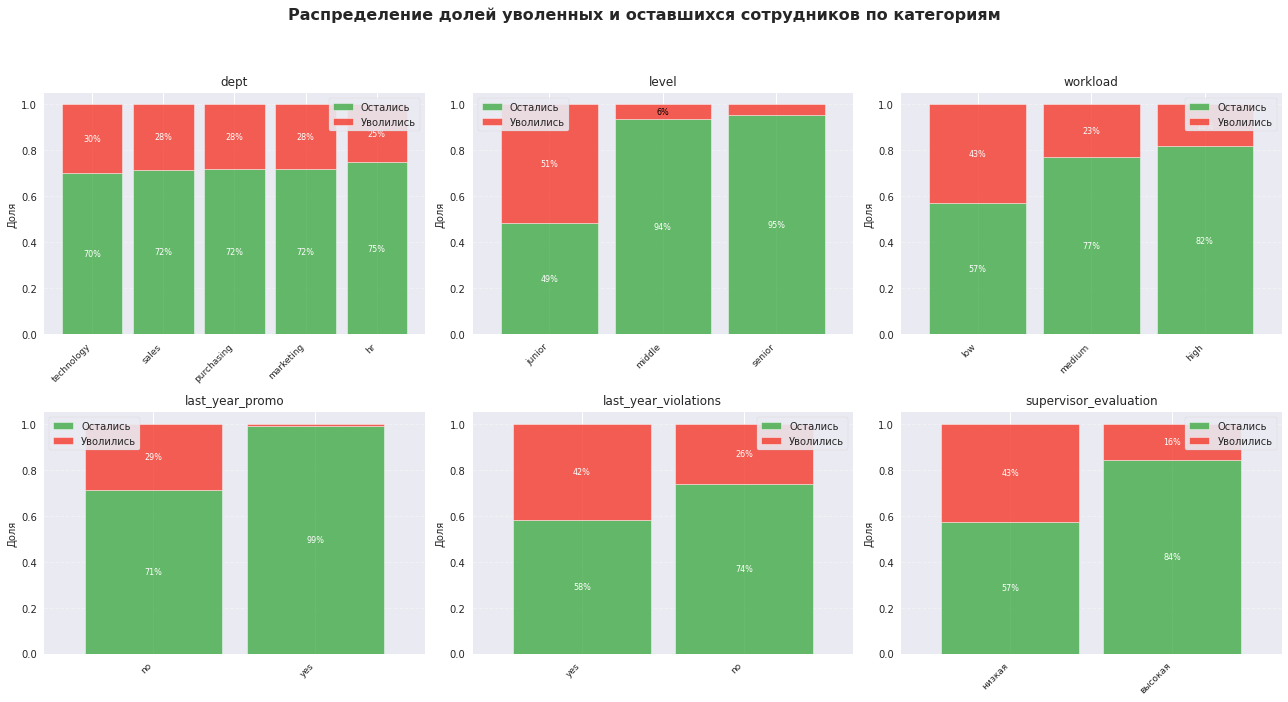

In [89]:
# Подготовка данных
cat_cols = X_train_full2.select_dtypes(include=['object', 'category']).columns.tolist()
if 'quit' in cat_cols:
    cat_cols.remove('quit')

# Создаем фигуру
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 22))
fig.suptitle('Распределение долей уволенных и оставшихся сотрудников по категориям', 
             y=1.02, fontsize=16, fontweight='bold')

# Цветовая палитра
colors = ['#4caf50', '#f44336']  # Зеленый - остались, Красный - уволились

for ax, col in zip(axes.flatten(), cat_cols):
    # Создаем и сортируем таблицу сопряженности
    crosstab = pd.crosstab(X_train_full2[col], X_train_full2['quit'], normalize='index')
    crosstab_sorted = crosstab.sort_values('yes', ascending=False)
    
    # Строим стекированный график
    crosstab_sorted.plot(kind='bar', stacked=True, color=colors, 
                        ax=ax, width=0.85, alpha=0.85, edgecolor='w', linewidth=0.5)
    
    # Настройки осей
    ax.set_title(col, fontsize=12, pad=8)
    ax.set_ylabel('Доля', fontsize=10)
    ax.set_xlabel('')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.legend(['Остались', 'Уволились'], frameon=True, framealpha=0.9)
    
    # Добавляем подписи значений
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        if height > 0.05:  # Подписываем только значимые доли
            x, y = p.get_xy()
            ax.annotate(f'{height:.0%}', (x + width/2, y + height/2), 
                        ha='center', va='center', fontsize=8,
                        color='white' if height > 0.15 else 'black')

# Удаляем пустые графики, если колонок меньше 15
for i in range(len(cat_cols), 15):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

## Проверка теории о влиянии оценки удовлетворенности сотрудника на его увольнение

Возьмем два датафрейма с целевыми признаками для тестовой выборки и объединим их.

In [54]:
rate_quit = pd.merge(y_test, y_test2, on = 'id')
rate_quit.head(10)

,id,job_satisfaction_rate,quit
0,100298,0.80,no
1,100480,0.84,no
2,100503,0.79,no
3,100610,0.75,no
4,100692,0.69,no
5,100710,0.68,no
6,100894,0.49,no
7,102102,0.73,no
8,102222,0.66,no
9,102320,0.26,no


Разделим на 2 категории: уволившиеся и нет.

In [55]:
quit_yes2 = rate_quit[X_train_full2['quit'] == 'yes']
quit_no2 = rate_quit[X_train_full2['quit'] == 'no']

Выведем графики распределения уровня оценки удовлетворения для обеих категорий.

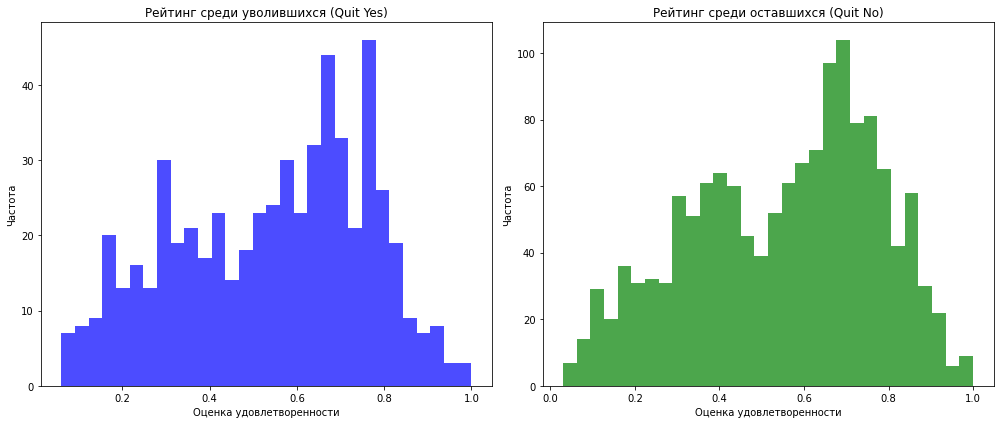

In [56]:
plt.figure(figsize=(14, 6))

# Первая гистограмма для quit_yes2
plt.subplot(1, 2, 1)
plt.hist(quit_yes2['job_satisfaction_rate'], bins=30, color='blue', alpha=0.7)
plt.title('Рейтинг среди уволившихся (Quit Yes)')
plt.xlabel('Оценка удовлетворенности')
plt.ylabel('Частота')

# Вторая гистограмма для quit_no2
plt.subplot(1, 2, 2)
plt.hist(quit_no2['job_satisfaction_rate'], bins=30, color='green', alpha=0.7)
plt.title('Рейтинг среди оставшихся (Quit No)')
plt.xlabel('Оценка удовлетворенности')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()

По графикам видно, что оценки удовлетворенности не сильно различаются. Можем утверждать, что графики похожи. 

Для большей уверенности расчитаем средние значения с помощью функции.

In [57]:
print(quit_yes2['job_satisfaction_rate'].mean())
quit_no2['job_satisfaction_rate'].mean()

0.5413471502590673


0.5518085855031668

**Вывод**

Числа близки между собой. Видимо этот показатель не сильно влияет на фактическое увольнение. 

Это может быть связано с тем, что сотрудники не всегда хотят отвечать правду в подобных тестированиях и склонны выбирать усредненные значения. Можно сделать вывод, что на увольнение оказывают влияние другие факторы.

<Figure size 864x504 with 0 Axes>

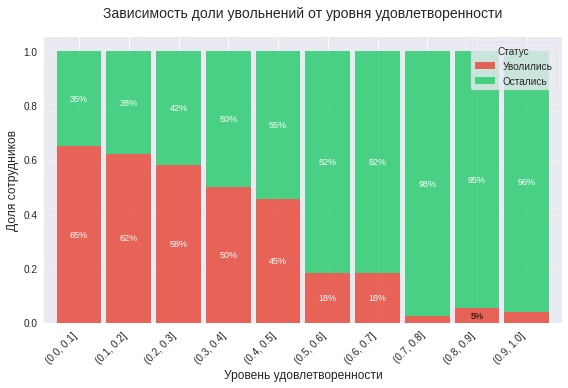

In [91]:
# Настройка стиля графиков
plt.style.use('seaborn')
plt.figure(figsize=(12, 7))

# Создаем бины для уровня удовлетворенности
bins = np.linspace(0, 1, 11)  # Разбиваем на 10 интервалов от 0 до 1
rate_quit['satisfaction_bin'] = pd.cut(rate_quit['job_satisfaction_rate'], bins=bins)

# Группируем данные по бинам и считаем долю уволившихся
grouped = rate_quit.groupby('satisfaction_bin')['quit'].value_counts(normalize=True).unstack()
grouped = grouped[['yes', 'no']].fillna(0)  # Убедимся, что порядок 'yes' перед 'no'

# Строим стекированный столбчатый график
ax = grouped.plot(kind='bar', stacked=True, color=['#e74c3c', '#2ecc71'], width=0.9, alpha=0.85)

# Настройка графика
plt.title('Зависимость доли увольнений от уровня удовлетворенности', pad=20, fontsize=14)
plt.xlabel('Уровень удовлетворенности', fontsize=12)
plt.ylabel('Доля сотрудников', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(['Уволились', 'Остались'], title='Статус', frameon=True)

# Добавляем подписи значений
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    if height > 0.05:  # Подписываем только значимые доли
        x, y = p.get_xy()
        ax.annotate(f'{height:.0%}', (x + width/2, y + height/2), 
                   ha='center', va='center', fontsize=9,
                   color='white' if height > 0.15 else 'black')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

Теперь мы действительно видим, что Увольнения зависят от уровня удовлетворенности. Начиная от уровня падения удовлетворенности с 5 и до 0, соответственно, сильно растет доля увольнения, почти 50% и больше. Тогда как при уровне удовлетворенности в 7 и выше сотрудники практически не увольняются.

## Добавление нового входного признака

Добавим в исходные датафреймы df_train_full и X_test новый входной признак, а именно уровень удовлетворенности, предсказанный лучшей моделью из первой задачи.

In [58]:
#разделим датафрейм на тестовую и тренировочную выборки
X_train2 = X_train_full2.drop(
        [
            'quit'
        ], 
        axis=1
    )
y_train2 = X_train_full2['quit']

y_train_pred2 = grid_search.predict(X_train2)
y_test_pred2 = grid_search.predict(X_test2)

In [59]:
# теперь добавим получившиеся предсказания в тренировочный и тестовый датафремы с входными признаками
X_train2['job_satisfaction_rate'] = y_train_pred2
X_test2['job_satisfaction_rate'] = y_test_pred2

# проверим что все в порядке
display(X_train2.head())
X_test2.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
2600,100222,sales,junior,medium,3,no,no,низкая,20400,0.350465
717,100459,purchasing,junior,medium,3,no,no,низкая,21600,0.371450
2455,100469,marketing,junior,medium,1,no,no,высокая,28800,0.679756
1592,100601,technology,middle,high,4,no,no,высокая,68400,0.789885
2657,100858,sales,junior,medium,2,no,no,высокая,25200,0.696176


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1172,100298,hr,junior,low,2,no,no,высокая,19200,0.784238
852,100480,marketing,junior,low,4,no,no,высокая,16800,0.790212
848,100503,purchasing,middle,high,5,no,no,высокая,55200,0.752669
524,100610,sales,middle,medium,5,no,no,высокая,43200,0.759909
476,100692,sales,middle,high,6,no,no,высокая,48000,0.694279


Мы получили 2 датафрейма с входными признаками для тестовой и тренировочной выборки. Добавили предсказанный признак, и убедились что все в порядке. Можно начинать выбор модели для решения задачи.

## Использование пайплайна

### Подготовка данных

In [60]:
#создадим списки для каждого кодирования

#для удобства выведем списки всех численных переменных, созданные ранее с помощью функции
num_columns = X_train2.select_dtypes(include=['float64','int64']).columns.tolist()
num_columns

['id', 'employment_years', 'salary', 'job_satisfaction_rate']

In [61]:
# и для категориальных значений
cat_columns = X_train2.select_dtypes(include=['object']).columns.tolist()
for column in cat_columns:
        unique_values = X_train2[column].unique()
        print(f"Уникальные значения для столбца '{column}': {unique_values}")

Уникальные значения для столбца 'dept': ['sales' 'purchasing' 'marketing' 'technology' 'hr']
Уникальные значения для столбца 'level': ['junior' 'middle' 'senior']
Уникальные значения для столбца 'workload': ['medium' 'high' 'low']
Уникальные значения для столбца 'last_year_promo': ['no' 'yes']
Уникальные значения для столбца 'last_year_violations': ['no' 'yes']
Уникальные значения для столбца 'supervisor_evaluation': ['низкая' 'высокая']


In [62]:
# признаки для OneHotEncoder
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']

# признаки для OrdinalEncoder
ord_columns = ['level', 'workload', 'supervisor_evaluation']

# численные признаки
num_columns = ['employment_years', 'salary', 'job_satisfaction_rate']

### Создание пайплайна

In [63]:
# cоздаём пайплайн для подготовки признаков из списка ohe_columns:
ohe_pipe = Pipeline([
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (    'ohe', 
            OneHotEncoder(sparse_output=False, handle_unknown='ignore',drop='first')
        )
])

In [64]:
# cоздаём пайплайн для подготовки признаков из списка ord_columns:
ord_pipe = Pipeline([
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['junior','middle','senior'],
                    ['low','medium','high'],
                    ['низкая', 'высокая']
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
       (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
])

In [65]:
# создаём общий пайплайн для объединения шагов подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)   
    ], 
    remainder =  'passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['dept', 'last_year_promo',
                                  'last_year_violations']),
                                ('ord',
                                 Pipeline(steps=[('simpleImputer_before_ord',
                                                  SimpleImputer(strategy='m...
                                                  OrdinalEncoder(categories=[['junior',
                                   

Так как в данном задании мы столкнулись с задачей классификации, мы будем пользоваться моделями для задач классификации, а не регрессии как в первой задаче.

In [66]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

Создаём словарь для каждой модели, в котором укажем гиперпараметры для дальнейшего перебора.

In [67]:
param_distributions = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'],
        'models__min_samples_split': range(2,20) ,
        'models__min_samples_leaf': range(2,20) ,
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability = True)],
        'models__kernel':('rbf','linear','poly'),
        'models__C': range(1,100),
        'models__degree': range(1,10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__solver': ('liblinear', 'saga', 'lbfgs'),
        'models__penalty': ('l1', 'l2', 'elasticnet', 'none'),
        'models__C': range(1,100),
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }

] 

##  Обучение моделей

Приступим к обучению наших моделей и автоматизированному подбору лучшей с помощью RandomizedSearchCV. Используем метрику **roc-auc** так как данные распределены не равномерно.

In [68]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [69]:
le = LabelEncoder()
y_train2 = le.fit_transform(y_train2)
y_train2

array([1, 1, 0, ..., 1, 0, 0])

Обучаем модель на тренировочной выборке.

In [70]:
randomized_search.fit(X_train2, y_train2)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                                                            'poly'),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': range(1, 100),
                                         'models__penalty': ('l1', 'l2',
                                                             'elasticnet',
                                                             'none'),
                                         'models__solver': ('liblinear', 'saga',
                                                            'lbfgs'),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [71]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика ROC_AUC лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [72]:
X_test2 = X_test2.sort_values(by = 'id')
y_test2 = y_test2.sort_values(by = 'id')

Рассчитаем метрику на тестовой выборке.

In [73]:
y_test2 = y_test2['quit']

In [74]:
y_test2 = le.transform(y_test2)
y_test2

array([0, 0, 0, ..., 1, 0, 1])

In [75]:
y_test_probas2 = randomized_search.predict_proba(X_test2)[:,1]
y_test_probas2

array([0.03892944, 0.03892944, 0.01102941, ..., 0.67871486, 0.        ,
       0.93693694])

In [76]:
print(y_test2.shape)
y_test_probas2.shape

(2000,)


(2000,)

In [77]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test2, y_test_probas2)}')

Метрика ROC-AUC на тестовой выборке: 0.9222376973073352


## Вывод по Задаче 2.

Мы достигли желаемого значения метрики ROC_AUC путем перебора всех моделей и всех гиперпараметров с помощью рандомного перебора RandomizedSearchCV. Лушая модель получилась - **DecisionTreeClassifier** с параметрами max_depth=6, max_features=14,min_samples_leaf=15, min_samples_split=14,random_state=42. 

Значение метрики на тренировочной выборке было получено - 0.926, а на тестовой - 0.922.

# Общий вывод

**Задачи**

1. Решить проблему предсказания оценки удовлетворенности сотрудника.
2. Предсказать возможное увольнение сотрудника из компании.

Обе эти задачи решаются с помощью моделей машинного обучение, а именно первая задача решается с помощью моделей регрессии, а вторая - модели для классификации.

**Загрузка данных**

* Датафреймы содержат данные, которые и должны в них содержаться. 
* Содержание соответствуют названию.
* Имелись пропуски значений, которые были обработаны в ходе создание пайплана.
* Типы данных соответствуют действительным.
* Дубликатов обнаружено не было.

**Предобработка данных**

* Исправлены опечатки в данных.
* Заполнены пропуски ' ' значением nan.
* Оценка качества работы сотрудника переведена в значения "низкая"(1-3) и "высокая"(4-5).

**Исследовательский анализ данных**

* Тренировочная и тестовая выборка одинаковы по процентному соотношению категориальных признаков между собой.
* Большинство работников (38%) работают в отделе продаж и почти 23% - в отделе технологий.
* Почти 50% - Junior специалисты, а 42% - Middle. Оставшиеся 8.5% - Senior.
* Чуть больше половины сотрудников загружены средне.
* Повышение в прошлом году было только у 3% рабочих
* Нарушение трудового договора наблюдалось у 13%.
* Сильный дисбаланс классов в некоторых данных.
* Корреляция между **оценкой работы сотрудника начальством** и **удовлетворенностью сотрудника**. 
* Мультиколлинеарности между входными признаками не обнаружено.
* Больше всего на целевой признак второй задачи влияют такие признаки как **зарплата** (0.56) и **годы стажа**(0.66).
* Мультиколлинеарности не обнаружено.

**Выводы по первой задаче**

Мы достигли желаемого показателя метрики, и достигли этого при помощи лучшей из подобранных моделей - LinearRegression(). Перебор был между деревом регрессии и линейной регрессией.

У входных данных была достаточная линейная зависимость с целевым признаком, из-за чего метрика получилась выше для ЛинейнойРегрессии.

**Выводы по второй задаче**

Мы достигли желаемого значения метрики ROC_AUC путем перебора всех моделей и всех гиперпараметров с помощью рандомного перебора RandomizedSearchCV. Лушая модель получилась - **DecisionTreeClassifier** с параметрами max_depth=6, max_features=14,min_samples_leaf=15, min_samples_split=14,random_state=42. 

Значение метрики на тренировочной выборке было получено - 0.926, а на тестовой - 0.922.

**Зависимость доли увольнения сотрудников от уровня удовлетворения**

Действительно, увольнения зависят от уровня удовлетворенности. Начиная от уровня падения удовлетворенности с 5 и до 0, соответственно, сильно растет доля увольнения, почти 50% и больше. Тогда как при уровне удовлетворенности в 7 и выше сотрудники практически не увольняются.

**Предложения для бизнеса**

Если говорить об удовлетворенности сотрудников, то скорее всего этот показатель в тесте не сильно влияет на действительное увольнение сотрудника, потому что в тесте реже выбирают резко отрицательные ответы. Достаточно о возможном увольнении говорит уровень зарплаты работника и стаж его работы. Больший процент уволившихся будет состоять из стажеров, которые только устроились, и у них маленький уровень зарплаты. Чем выше зарпалата и чем дольше человек работает в организации - тем ниже шанс, что он решит уволиться.